In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.stats import t
from scipy import stats
from pypfopt import black_litterman
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier

#Per fare dei bei grafici che si leggano
plt.rcParams.update({'font.size':14})

#Dataframe stocks
df_WEC = pd.read_csv("WEC.N.csv")
df_JNJ = pd.read_csv("JNJ.N.csv")
df_QCOM = pd.read_csv("QCOM.OQ.csv")
df_TDY = pd.read_csv("TDY.N.csv")
df_PEP = pd.read_csv("PEP.OQ.csv")

#Dataframe S&P500
df_SPX = pd.read_csv("SPX.csv")

## Punto 1


La prima parte si concentra sul data analysis del campione. In particolare, cerchiamo di capire quanti Nan vi siano e se si può fare dell'inferenza per capire come sostituire i valori. Controlliamo se vi siano Nan in ogni data set e visualizziamo i vari dati sul campione.

In [2]:
print("WEC Dataset\n")
print(df_WEC.info(),df_WEC.describe())
print("\nJNJ Dataset\n")
print(df_JNJ.info(),df_JNJ.describe())
print("\nQCOM Dataset\n")
print(df_QCOM.info(),df_QCOM.describe())
print("\nTDY Dataset\n")
print(df_TDY.info(),df_TDY.describe())
print("\nPEP Dataset\n")
print(df_PEP.info(),df_PEP.describe())

WEC Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            251 non-null    int64  
 1   Instrument            251 non-null    object 
 2   Date                  251 non-null    object 
 3   1 Month Total Return  251 non-null    float64
 4   Company Market Cap    251 non-null    float64
 5   Price Close           251 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 11.9+ KB
None        Unnamed: 0  1 Month Total Return  Company Market Cap  Price Close
count  251.000000            251.000000        2.510000e+02   251.000000
mean   125.000000              1.172101        1.498314e+10    51.694681
std     72.601653              4.611845        9.915640e+09    28.445197
min      0.000000            -13.569150        3.712649e+09    15.700000
25%     62.500000             -1.690880   

In [3]:
#Converto le date in un formato leggibile
df_WEC['Date'] = pd.to_datetime(df_WEC['Date']).dt.date
df_JNJ['Date'] = pd.to_datetime(df_JNJ['Date']).dt.date
df_QCOM['Date'] = pd.to_datetime(df_QCOM['Date']).dt.date
df_TDY['Date'] = pd.to_datetime(df_TDY['Date']).dt.date
df_PEP['Date'] = pd.to_datetime(df_PEP['Date']).dt.date

Avendo constatato che non vi siano problemi con i dati dei vari campioni, proseguiamo con una rappresentazione grafica.

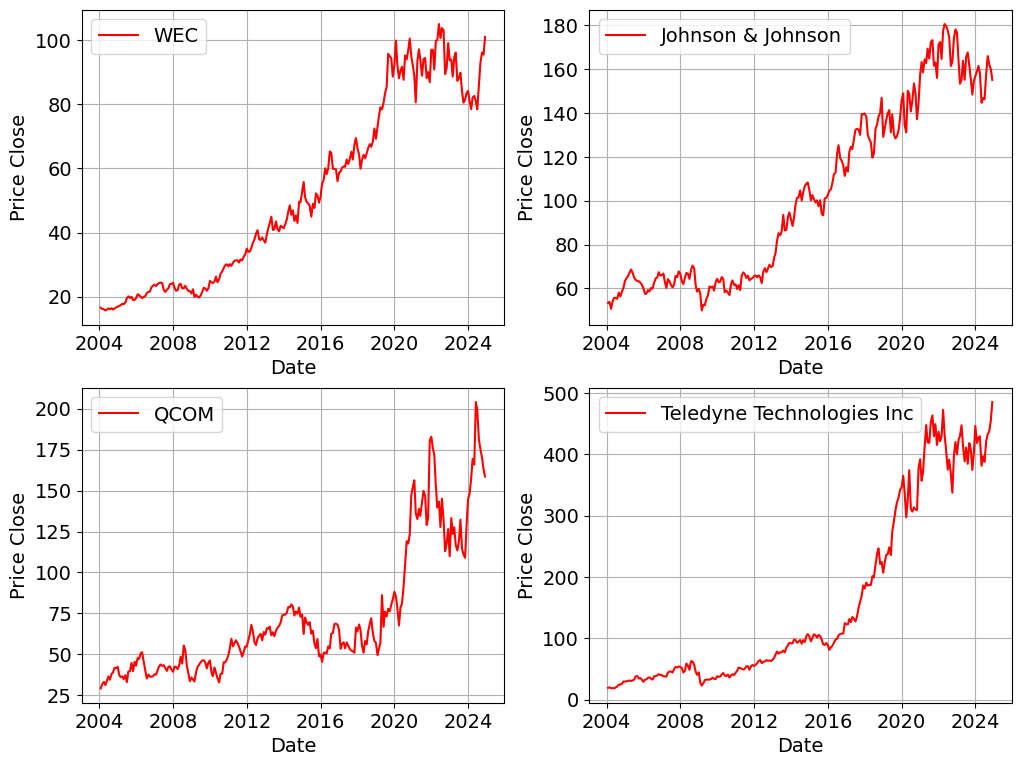

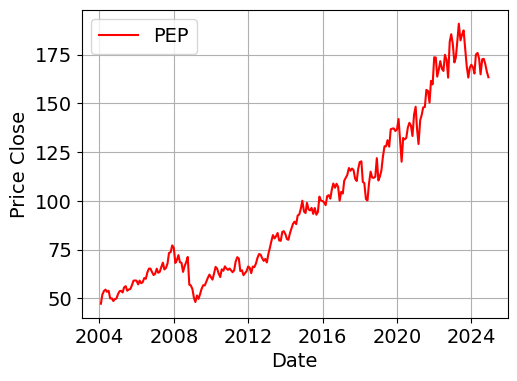

In [4]:
f, axes = plt.subplots(2, 2,figsize=(12,9))
sns.lineplot(x="Date",y="Price Close",data=df_WEC, ax=axes[0,0],c="r",label="WEC")
sns.lineplot(x="Date",y="Price Close",data=df_JNJ, ax=axes[0,1],c="r",label="Johnson & Johnson")
sns.lineplot(x="Date",y="Price Close",data=df_QCOM, ax=axes[1,0],c="r",label="QCOM")
sns.lineplot(x="Date",y="Price Close",data=df_TDY, ax=axes[1,1],c="r",label="Teledyne Technologies Inc")
axes[1,0].grid()
axes[0,1].grid()
axes[0,0].grid()
plt.tight_layout
plt.grid()
plt.figure(figsize=(5.5,4))
sns.lineplot(x="Date",y="Price Close",data=df_PEP,c="r",label="PEP")
plt.grid()
plt.tight_layout
plt.legend()

Creiamo un dataframe contenente il Close Price delle stock.

In [5]:
df_price_close= pd.DataFrame({"Close PEP":df_PEP["Price Close"].values})
df_price_close["Close TDY"] = df_TDY["Price Close"].values
df_price_close["Close WEC"] = df_WEC["Price Close"].values
df_price_close["Close JNJ"] = df_JNJ["Price Close"].values
df_price_close["Close QCOM"] = df_QCOM["Price Close"].values

Creiamo un dataframe contenente i Monthly Return delle stock.

In [6]:
df_return_month = pd.DataFrame({"Monthly Return PEP":df_PEP["1 Month Total Return"].values})
df_return_month["Monthly Return TDY"] = df_TDY["1 Month Total Return"].values
df_return_month["Monthly Return WEC"] = df_WEC["1 Month Total Return"].values
df_return_month["Monthly Return JNJ"] = df_JNJ["1 Month Total Return"].values
df_return_month["Monthly Return QCOM"] = df_QCOM["1 Month Total Return"].values

Visualizziamo la correlazione tra le varie stock sia per il close price, sia per il monthly average return.

Matrici di covaranza e correlazione per il close price e matrici inverse

In [7]:
cov_close = df_price_close.cov(numeric_only=True).values
corr_close = df_price_close.corr(numeric_only=True).values
inv_corr_close = np.linalg.inv(corr_close)
inv_cov_close = np.linalg.inv(cov_close)

Matrici di covaranza e correlazione per il monthly price e matrici inverse

In [8]:
cov_mon = df_return_month.cov(numeric_only=True).values
corr_mon = df_return_month.corr(numeric_only=True).values
inv_corr_mon = np.linalg.inv(df_return_month.corr(numeric_only=True).values)
inv_cov_mon = np.linalg.inv(df_return_month.cov(numeric_only=True).values)

Heat maps per visualizzare le matrici di correlazione

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

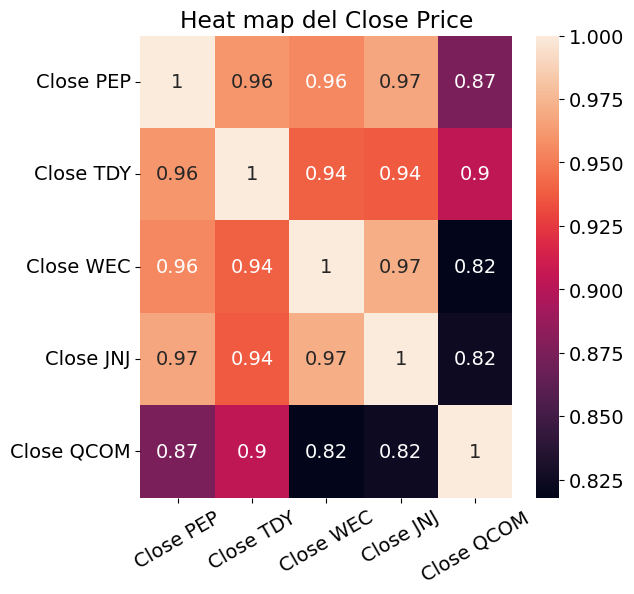

In [9]:
plt.figure(figsize=(6,6))
plt.title("Heat map del Close Price")
sns.heatmap(df_price_close.corr(numeric_only=True),annot=True)
plt.xticks(rotation=30)
plt.tight_layout

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

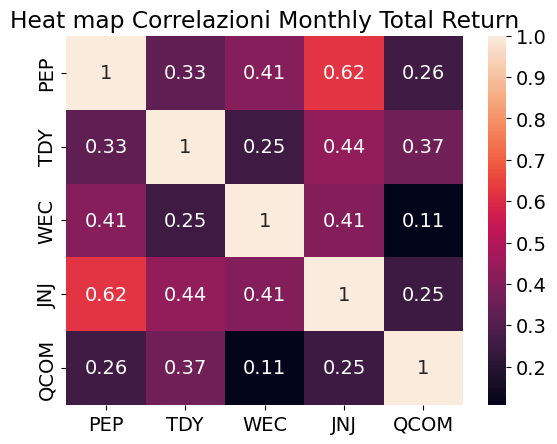

In [10]:
plt.title("Heat map Correlazioni Monthly Total Return")
sns.heatmap(df_return_month.corr(numeric_only=True),annot=True,xticklabels=['PEP','TDY','WEC','JNJ','QCOM'],yticklabels=['PEP','TDY','WEC','JNJ','QCOM'])
plt.tight_layout

## Punto 2

Guardiamo alla volatilità delle stock. Per far ciò, proseguiamo con una rappresentazione grafica dei monthly return.

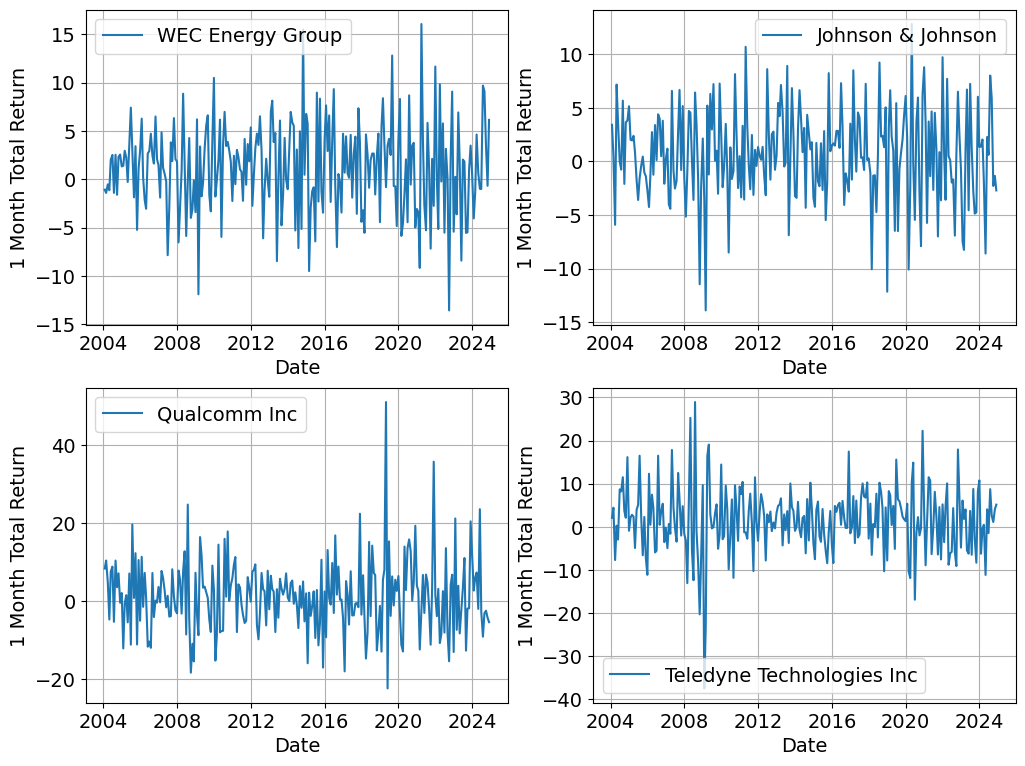

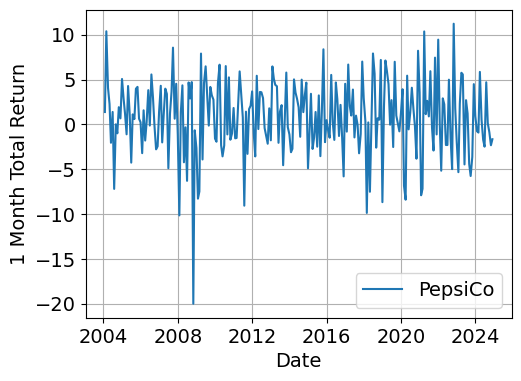

In [11]:
f, axes = plt.subplots(2, 2,figsize=(12,9))
sns.lineplot(x="Date",y="1 Month Total Return",data=df_WEC, ax=axes[0,0],label="WEC Energy Group")
sns.lineplot(x="Date",y="1 Month Total Return",data=df_JNJ, ax=axes[0,1],label="Johnson & Johnson")
sns.lineplot(x="Date",y="1 Month Total Return",data=df_QCOM, ax=axes[1,0],label="Qualcomm Inc")
sns.lineplot(x="Date",y="1 Month Total Return",data=df_TDY, ax=axes[1,1],label="Teledyne Technologies Inc")
axes[1,0].tick_params(rotation=0)
axes[1,0].grid()
axes[0,1].grid()
axes[0,0].grid()
plt.tight_layout
plt.grid()
plt.figure(figsize=(5.5,4))
sns.lineplot(x="Date",y="1 Month Total Return",data=df_PEP,label="PepsiCo")
#plt.axhline(df_PEP["1 Month Total Return"],c="r")
plt.grid()
plt.tick_params(rotation=0)
plt.tight_layout
plt.legend()

<Axes: title={'center': 'Distribuzione dei rendimenti mensili'}, ylabel='Count'>

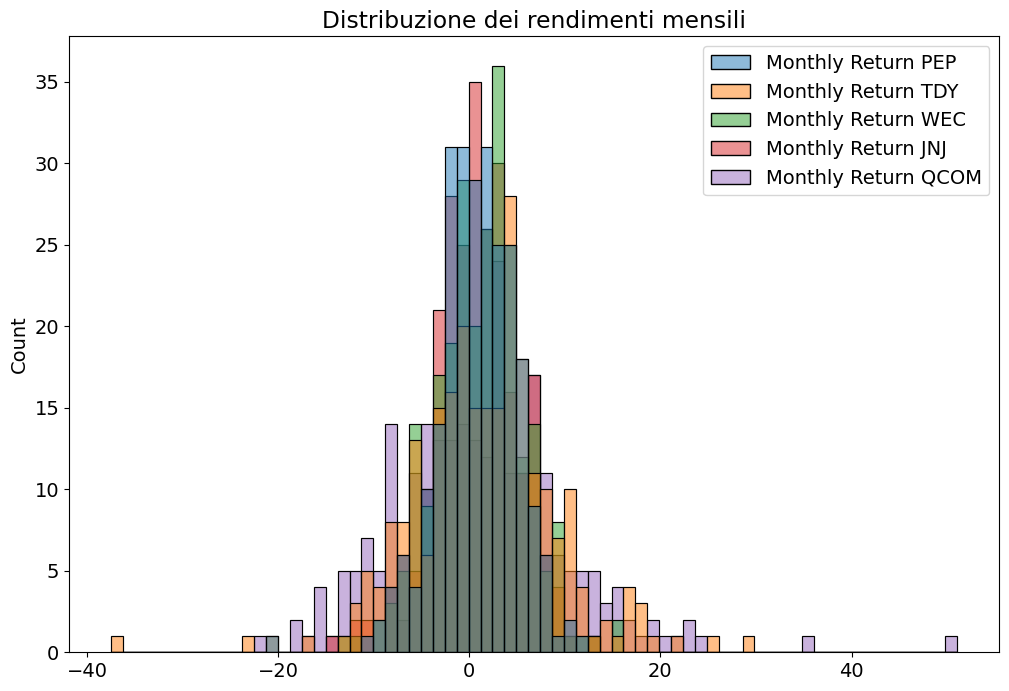

In [12]:
plt.figure(figsize=(12,8))
plt.title("Distribuzione dei rendimenti mensili")
sns.histplot(data=df_return_month)

Per fare il moving average utilizziamo una funzione pandas e visualizziamo l'andamento delle medie.

In [13]:
print("Media semplice dei ritorni mensili")
print(df_return_month.mean())
print("Media con pesi esponenziali dei ritorni mensili")
print((df_return_month.ewm(alpha = 0.02).mean()).mean())

Media semplice dei ritorni mensili
Monthly Return PEP     0.752906
Monthly Return TDY     1.578560
Monthly Return WEC     1.172101
Monthly Return JNJ     0.670205
Monthly Return QCOM    1.236432
dtype: float64
Media con pesi esponenziali dei ritorni mensili
Monthly Return PEP     0.881602
Monthly Return TDY     1.731393
Monthly Return WEC     1.144055
Monthly Return JNJ     0.774214
Monthly Return QCOM    1.422470
dtype: float64


/tmp/ipykernel_33800/1692114235.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.lineplot(data=ema_df).set_xticklabels(["",  "2004", "2008", "2012", "2016", "2020", "2024"])


Text(0, 0.5, 'Exponential Moving Average')

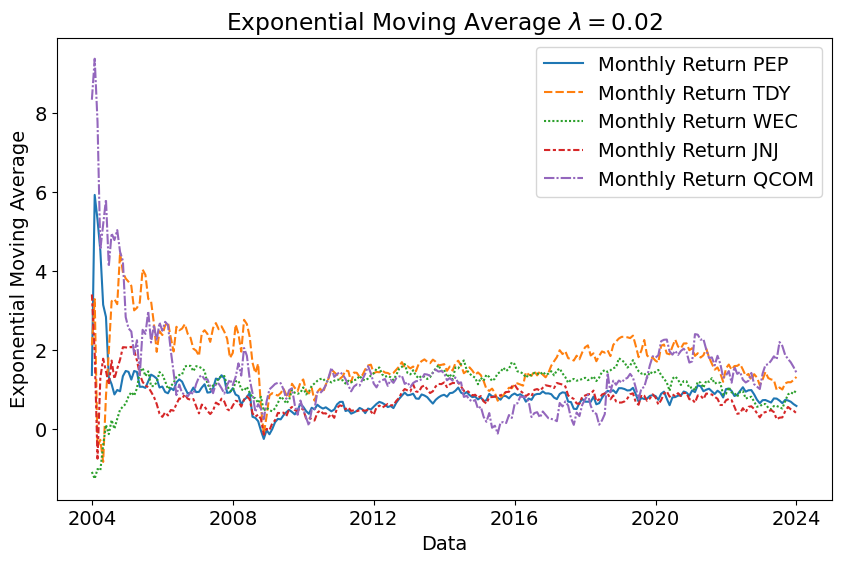

In [14]:
ema_df = df_return_month.ewm(alpha=0.02).mean()
plt.figure(figsize=(10,6))
plt.title(r"Exponential Moving Average $\lambda = 0.02$")
sns.lineplot(data=ema_df).set_xticklabels(["",  "2004", "2008", "2012", "2016", "2020", "2024"])
plt.xlabel("Data")
plt.ylabel("Exponential Moving Average")

/tmp/ipykernel_33800/1424730417.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.lineplot(data=sma_df).set_xticklabels(["",  "2004", "2008", "2012", "2016", "2020", "2024"])


Text(0, 0.5, 'Simple Moving Average')

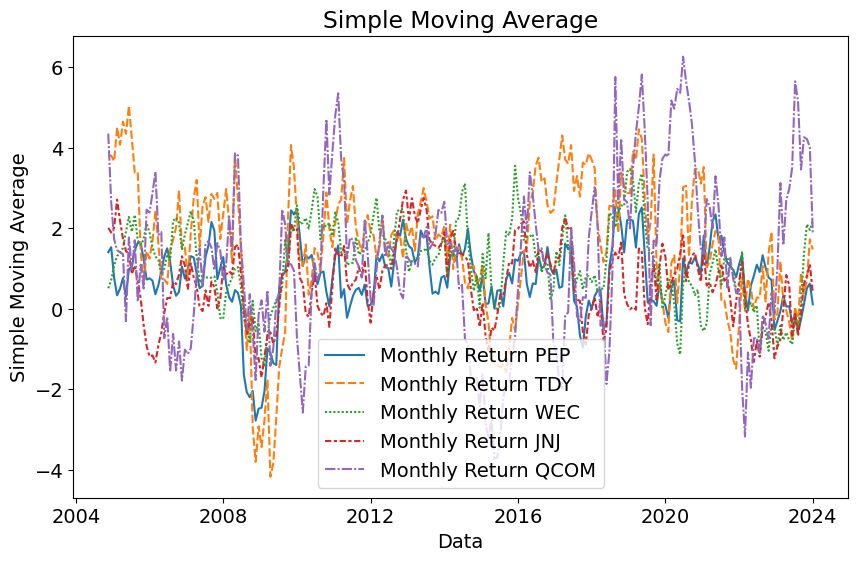

In [15]:
plt.figure(figsize=(10,6))
plt.title(r"Simple Moving Average")
sma_df = df_return_month.rolling(window=12).mean()
sns.lineplot(data=sma_df).set_xticklabels(["",  "2004", "2008", "2012", "2016", "2020", "2024"])
plt.xlabel("Data")
plt.ylabel("Simple Moving Average")

Analizziamo la matrice di correlazione.

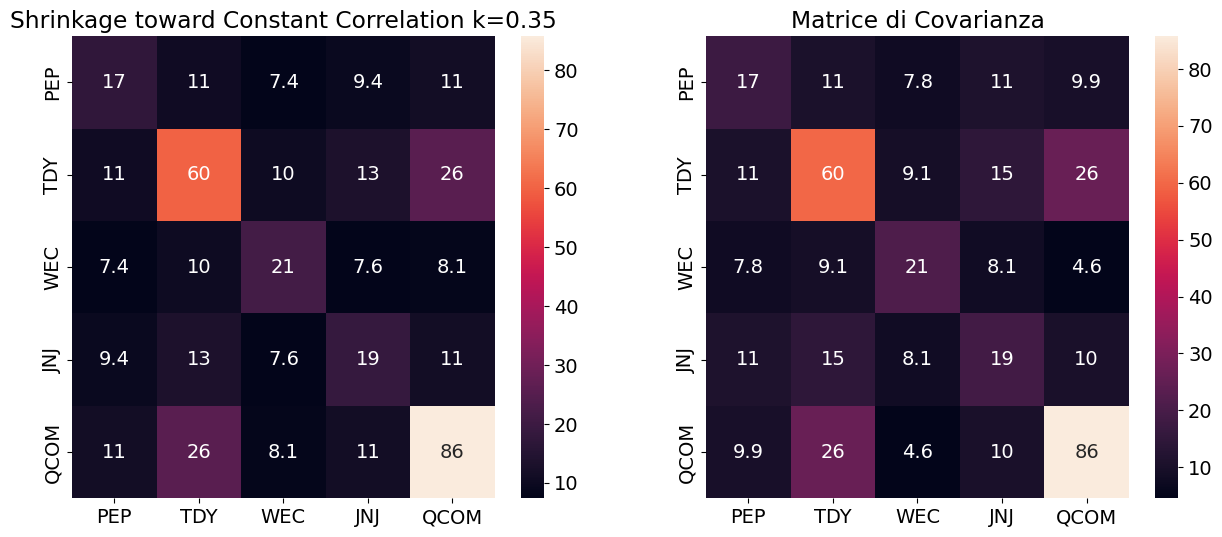

In [16]:
# Calcoliamo la corelazione media
avg_corr = (np.sum(corr_mon) - len(corr_mon)) / (len(corr_mon) * (len(corr_mon) - 1))

# Matrice di correlazione costante
const_corr = np.full(corr_mon.shape, avg_corr)
np.fill_diagonal(const_corr, 1)

#Matrice con shrinkage
k = 0.35
shrinkage_cov = k * (np.outer(np.sqrt(np.diag(cov_mon)), np.sqrt(np.diag(cov_mon))) * const_corr) + (1 - k) * cov_mon

shrinkage_cov = pd.DataFrame(shrinkage_cov, index=df_return_month.columns, columns=df_return_month.columns)

fig,ax = plt.subplots(1,2, figsize=(15, 6))

ax[0].set_title("Shrinkage toward Constant Correlation k=0.35")
sns.heatmap(shrinkage_cov,annot=True,ax=ax[0],xticklabels=['PEP','TDY','WEC','JNJ','QCOM'],yticklabels=['PEP','TDY','WEC','JNJ','QCOM'])

ax[1].set_title("Matrice di Covarianza")
sns.heatmap(df_return_month.cov(numeric_only=True),annot=True,ax=ax[1],xticklabels=['PEP','TDY','WEC','JNJ','QCOM'],yticklabels=['PEP','TDY','WEC','JNJ','QCOM'])

plt.tight_layout
plt.show()

## Punto 3

La teoria di Markowitz senza titolo risk free dice che:
$$\mu_p = \sum_i w_i\mu_i\,,\quad \sigma^2_p = \sum_{i,j}\sigma_{ij} w_i w_j\,,$$
Definiamo un lagrangiana $\mathcal{L}$ tale che la stessa sia minimizzata da un certo $w^*$.

Trovati i valori della lagrangiana, individuiamo un legame tra la volatilità e il rendimento atteso, da cui il portafoglio a minima varianza \
L'equazione per il frontiera efficiente (Markowitz bullet) è data da (si utilizza la notazione di Einstein con somma su indici ripetuti)
$$\sigma^2_p = \frac{D\mu_p^2-2B\mu_p+A}{det(M)}\,,$$

$$w^i = \sigma^{ik}\left(\frac{D\mu_p-B}{\det(M)} \mu_k + \frac{A-B\mu_p}{\det(M)} e_k\right)$$

$$
        \lambda = \frac{D\mu_p-B}{\det(M)}\,,\quad
        \gamma = \frac{A-B\mu_p}{\det(M)}\,,
$$
$$
D= \sigma^{ij}e_i e_j\,,\quad B = \sigma^{ij}e_i \mu_j\,, \quad A = \sigma^{ij}\mu_i \mu_j\,, \quad \det(M) = DA-B^2
        $$
Con $e=(1,\dots,1)$ e $\mu_i$ rendimenti dei singoli asset.

In [17]:
Rf = 0.03 #0.03 == annual risk-free return
Rf_mon = 100*((1+Rf)**(1/12)-1) # ritorno risk-free mensile in %

mu = df_return_month.mean().to_numpy()

# mu_p è l'expected return del portafoglio, mentre mu dei singoli assets
mu_p = inv_cov_mon @ mu

e = np.ones(len(mu))
A = inv_cov_mon @ mu @ mu
B = inv_cov_mon @ mu @ e
D = inv_cov_mon @ e @ e
det = A*D - B*B

# w sono i pesi del portafoglio ottimale, massimizando lo sharp ratio con rf=0.
norm = np.sum(mu_p)
w = mu_p/B

print("Pesi portafoglio ottimale:", w,"somma w: ",sum(w))

Pesi portafoglio ottimale: [ 0.20825531  0.21966803  0.60166139 -0.11487859  0.08529386] somma w:  1.0000000000000002


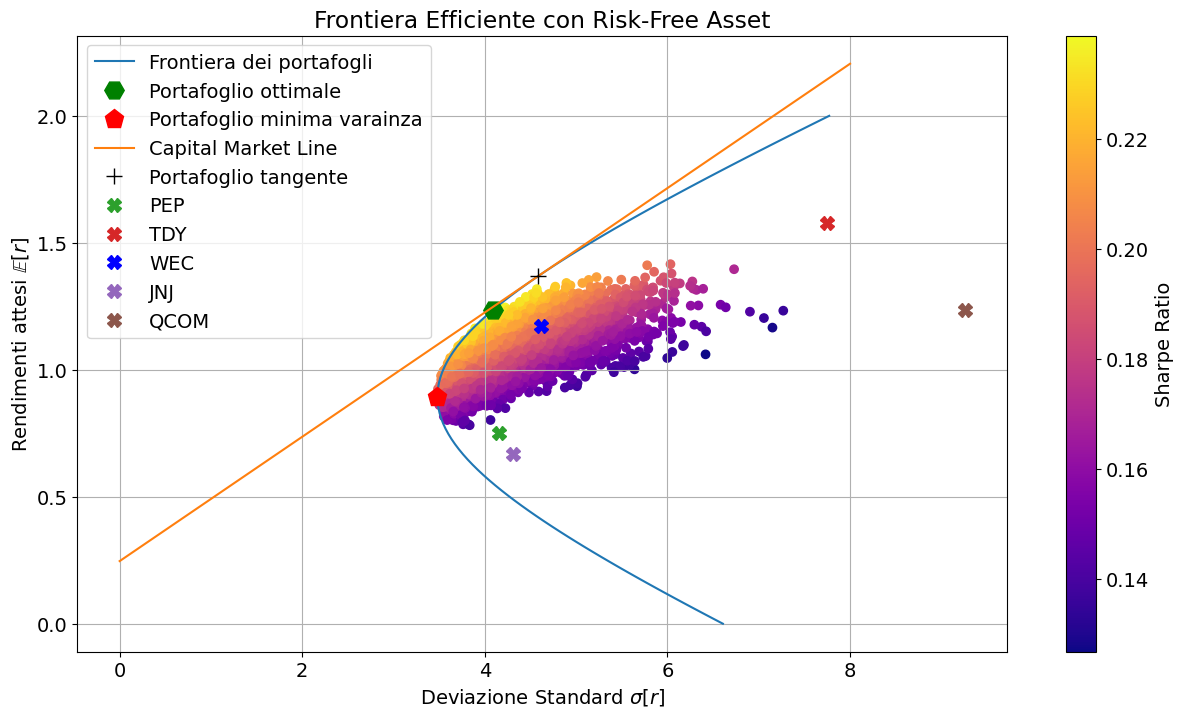

In [18]:
mu_var = np.linspace(0,2,100)
sigma_var = np.linspace(0,8,100)

mu_opt = mu@w
sigma_opt = np.sqrt(cov_mon @ w @ w)

mu_bullet = []
sigma_bullet = []

for i in range(5000):
    random_weight = np.random.uniform(0, 1, 5)
    random_weight /= np.sum(random_weight)
    mu_bullet.append(random_weight@mu)
    sigma_bullet.append(np.sqrt(cov_mon@random_weight@random_weight))

sharp_ratio = (mu_bullet-Rf_mon*np.ones(len(mu_bullet)))/sigma_bullet

plt.figure(figsize=(15,8))
plt.title("Frontiera Efficiente con Risk-Free Asset")

scatter = plt.scatter(x=sigma_bullet, y=mu_bullet, cmap='plasma', c=sharp_ratio)
plt.plot(np.sqrt((D*mu_var**2-2*B*mu_var+A)/det),mu_var,label = "Frontiera dei portafogli")
plt.plot(sigma_opt, mu_opt, color="g", marker="H", markersize=14,ls='', label = "Portafoglio ottimale")

plt.plot(np.sqrt(1/D),B/D, markersize=14, marker = "p",c="r",ls='', label = "Portafoglio minima varainza")
plt.plot(sigma_var,Rf_mon+np.sqrt(A + Rf_mon*(D*Rf_mon-2*B))*sigma_var, label= "Capital Market Line")
plt.plot(np.sqrt(A+Rf_mon*(-2*B+D*Rf_mon))/np.abs(B-D*Rf_mon),Rf_mon + (A+Rf_mon*(-2*B+D*Rf_mon))/np.abs(B-D*Rf_mon),ls='',markersize=12,marker ="+",c="k", label= "Portafoglio tangente")

plt.plot(np.sqrt(cov_mon[0,0]),mu[0], marker="X", markersize=10,ls='',label="PEP")
plt.plot(np.sqrt(cov_mon[1,1]),mu[1], marker="X", markersize=10,ls='',label="TDY")
plt.plot(np.sqrt(cov_mon[2,2]),mu[2], marker="X", markersize=10,ls='',label="WEC",c="b")
plt.plot(np.sqrt(cov_mon[3,3]),mu[3], marker="X", markersize=10,ls='',label="JNJ")
plt.plot(np.sqrt(cov_mon[4,4]),mu[4], marker="X", markersize=10,ls='',label="QCOM")

# Creo una colorbar per il S.R.
cbar = plt.colorbar(scatter)
cbar.set_label("Sharpe Ratio")

plt.xlabel(r"Deviazione Standard $\sigma[r]$")
plt.ylabel(r"Rendimenti attesi $\mathbb{E}[r] $")

plt.legend()
plt.grid(True)

plt.show()

#### Mostriamo i pesi dei vari portafogli

/tmp/ipykernel_33800/3437562003.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.barplot(w,edgecolor="k",linewidth=1.5,ax=ax[0]).set_xticklabels(["PEP", "TDY", "WEC", "JNJ", "QCOM"])
/tmp/ipykernel_33800/3437562003.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.barplot(w_tg,edgecolor="k",linewidth=1.5,ax=ax[1]).set_xticklabels(["PEP", "TDY", "WEC", "JNJ", "QCOM"])
/tmp/ipykernel_33800/3437562003.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.barplot(w_minVar,edgecolor="k",linewidth=1.5,ax=ax[2]).set_xticklabels(["PEP", "TDY", "WEC", "JNJ", "QCOM"])


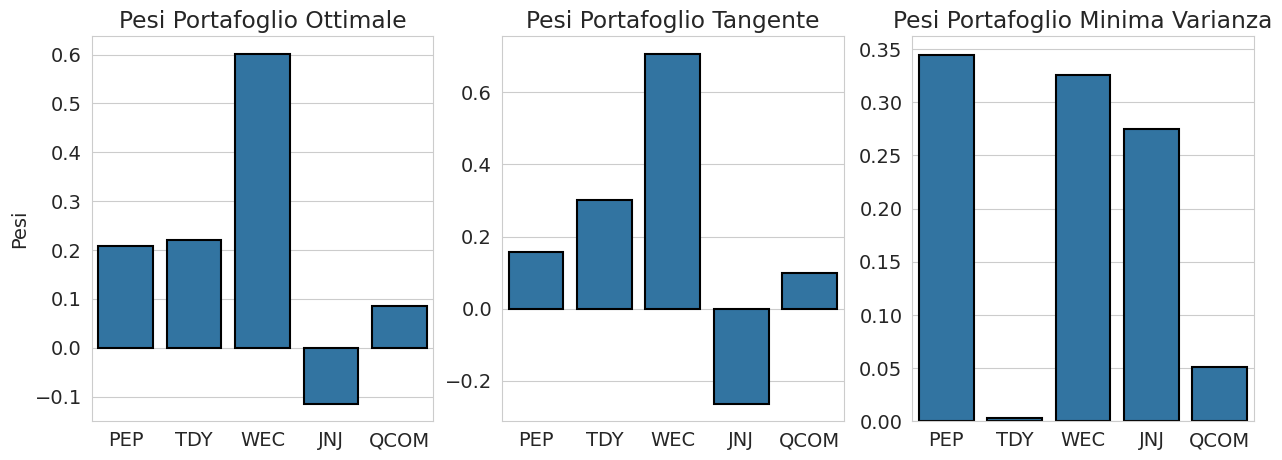

B/D > Rf: 0.8939605951539228 0.24662697723036864
Pesi Portafoglio Tangente [ 0.15619736  0.30216644  0.70668201 -0.26348025  0.09843444]
Pesi Portafoglio Ottimale [ 0.20825531  0.21966803  0.60166139 -0.11487859  0.08529386]
Pesi Portafoglio Minima Varainza [0.34489431 0.0031305  0.32600876 0.27516328 0.05080315]


In [19]:
w_minVar = inv_cov_mon@e/D
mu_t = Rf_mon + (A+Rf_mon*(-2*B+D*Rf_mon))/np.abs(B-D*Rf_mon)
w_tg = inv_cov_mon@((D*mu_t-B)*mu+(A-mu_t*B)*e)/det

sns.set_style("whitegrid")

fig,ax = plt.subplots(1,3, figsize=(15, 5))

ax[0].set_title("Pesi Portafoglio Ottimale")
sns.barplot(w,edgecolor="k",linewidth=1.5,ax=ax[0]).set_xticklabels(["PEP", "TDY", "WEC", "JNJ", "QCOM"])
ax[0].set_ylabel("Pesi")

ax[1].set_title("Pesi Portafoglio Tangente")
sns.barplot(w_tg,edgecolor="k",linewidth=1.5,ax=ax[1]).set_xticklabels(["PEP", "TDY", "WEC", "JNJ", "QCOM"])

ax[2].set_title("Pesi Portafoglio Minima Varianza")
sns.barplot(w_minVar,edgecolor="k",linewidth=1.5,ax=ax[2]).set_xticklabels(["PEP", "TDY", "WEC", "JNJ", "QCOM"])
plt.show()

print("B/D > Rf:",B/D,Rf_mon)
print("Pesi Portafoglio Tangente",w_tg)
print("Pesi Portafoglio Ottimale",w)
print("Pesi Portafoglio Minima Varainza",w_minVar)

## Punto 4

Confrontiamo la frontiera trovata in precedenza con quelle vincolate. Entrambe sono state derivate analiticamente, ma vista la difficolta di implementare il vincolo $w\geq0.1$ si è preferito usare la libreria minimize di scipy.

/home/riccardomartelli/.local/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


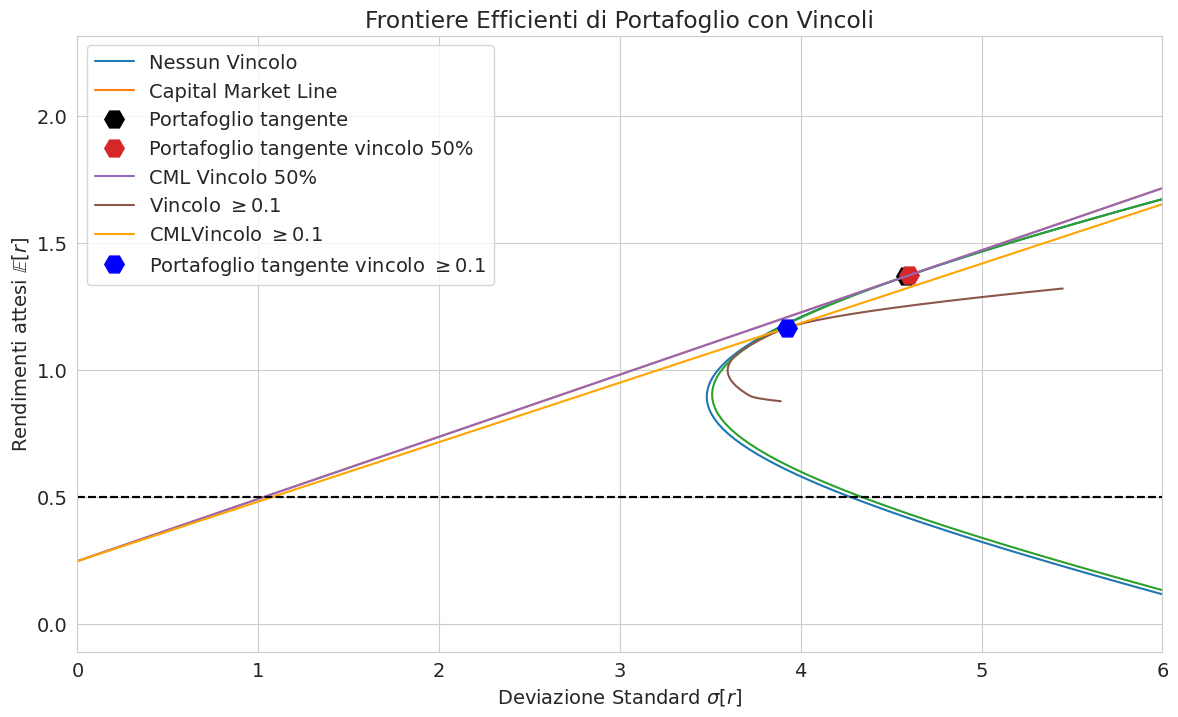

In [20]:
plt.figure(figsize=(14,8))

plt.plot(np.sqrt((D*mu_var**2-2*B*mu_var+A)/det),mu_var,label = "Nessun Vincolo")
plt.plot(sigma_var,Rf_mon+np.sqrt(A + Rf_mon*(D*Rf_mon-2*B))*sigma_var, label= "Capital Market Line")
plt.plot(np.sqrt(A+Rf_mon*(-2*B+D*Rf_mon))/np.abs(B-D*Rf_mon),Rf_mon + (A+Rf_mon*(-2*B+D*Rf_mon))/np.abs(B-D*Rf_mon),ls='',markersize=14,marker ="H",c="k", label= "Portafoglio tangente")

mu_p = np.linspace(0,2,100)
mu_l = np.linspace(0,8,100)

k = 0.5 #Vincolo 50%

di = [1,1,0,0,0]

ones = np.ones(len(mu))

#Parametri per vincolo con somma 50%
a = inv_cov_mon @ ones @ ones
b = inv_cov_mon @ mu @ ones
c = inv_cov_mon @ ones @ di
d = inv_cov_mon @ mu @ mu
e = inv_cov_mon @ di @ mu
f = inv_cov_mon @ di @ di

#Frontiera efficace esatta
def varVinc1(mup):
   return((e**2 - 2*b*e*k + b**2*k**2 - d*(f - 2*c*k + a*k**2))+2 * (b*f + a*e*k - c*(e + b*k)) * mup+(c**2 - a*f) * mup**2)/(c**2*d - 2*b*c*e + b**2*f + a*(e**2 - d*f))

sigma_1 = np.sqrt(varVinc1(mu_p))

plt.plot(sigma_1,mu_p)

#mu-sigma portafoglio tangente
mu_tg = (-e**2 + 2*b*e*k + d*(f + k*(-2*c + a*k)) + e*(c - a*k)*Rf_mon - b*(b*k**2 + (f - c*k)*Rf_mon))/(b*f + a*e*k - c*(e + b*k) + c**2*Rf_mon - a*f*Rf_mon)
sigma_tg = np.sqrt(varVinc1(mu_tg))

plt.plot(sigma_tg,mu_tg,marker="H",markersize=14,ls='',label="Portafoglio tangente vincolo 50%")
plt.plot(mu_l,(mu_tg-Rf_mon)/(sigma_tg)*(mu_l)+Rf_mon,label="CML Vincolo 50%")
plt.axhline(y=0.5, color="black", linestyle="--")
plt.legend()

mu_p = np.linspace(0.876,1.32,1000)
Pesi = []
VarPort = []

for m in mu_p:
    def SommaUno(w):
        return np.sum(w) - 1

    def RendPortafoglio(w):
        return  mu@w - m

    def Vincolo(w):
        return w - 0.1

    def VarPortafoglio(w):
        return w.T @ cov_mon @ w

    w0 = np.ones(5)/5
    constraints = [{'type': 'eq', 'fun': RendPortafoglio},
                   {'type': 'eq', 'fun': SommaUno},
                   {'type': 'ineq', 'fun': Vincolo}]
    bounds = [(0.1, None) for _ in range(5)]

    result = minimize(VarPortafoglio, w0, method='SLSQP', constraints=constraints, bounds=bounds)

    Pesi.append(result.x)
    VarPort.append(result.fun)


# Assuming mu_p, VarPort, and rf_mon are already defined
std = np.sqrt(VarPort)
sigma_range = np.linspace(0, 6, 500)

sharpe_ratios = (mu_p - Rf_mon) / std

# Trovo il valore che massimizza lo sharpe ratio
max_sharpe_idx = np.argmax(sharpe_ratios)
mu_m = mu_p[max_sharpe_idx]
sigma_m = std[max_sharpe_idx]

# CML equation

plt.plot(std,mu_p,label=r"Vincolo $\geq 0.1$")
plt.plot(sigma_range, Rf_mon + ((mu_m - Rf_mon) / sigma_m) * sigma_range, label=r'CMLVincolo $\geq 0.1$', color='orange')
plt.plot(sigma_m, mu_m, color='b', marker ="H",ls="", markersize=14, label=r'Portafoglio tangente vincolo $\geq 0.1$',zorder=5)
plt.legend()

plt.axhline(y=0.5, color="black", linestyle="--")
plt.xlim(0,6)
plt.title('Frontiere Efficienti di Portafoglio con Vincoli')
plt.xlabel(r"Deviazione Standard $\sigma[r]$")
plt.ylabel(r"Rendimenti attesi $\mathbb{E}[r] $")
plt.legend()
plt.grid(True)
plt.show()

Siccome abbiamo un vincolo $\mu_p \geq k\cdot \mu$ (con k vettore contenente solo 0.1), verifichiamo che il portafoglio 0.5% di rendimento possa esistere. Tuttavia il risultato è sopra 0.5%, dunque quindi non può esistere. (Questo solo per il vincolo w $\geq$ 0.1). Da notare che la disuguaglianza è valida perché i rendimenti degli asset mu sono positivi, ed ovviamente anche le altre due componenti.

In [21]:
np.ones(5)/10@mu

0.5410205351569177

k non è un portafoglio plausibile perché non somma a uno. Invece un portafoglio con un elemtento 0.6 e gli altri 0.1 si. Di fatto esiste nel nostro caso ed ha forma [0.1,0.1,0.1,0.6,0.1], corrispondendo al valore minimo di rendimento. Il suo valore è riportato sotto e si nota che supera abbondantemente il valore 0.5 richiesto.

In [22]:
np.min(Pesi@mu)

0.8761235861172564

/tmp/ipykernel_33800/1381687757.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.barplot(w_05,edgecolor="k",linewidth=1.5,ax=ax[0]).set_xticklabels(["PEP", "TDY", "WEC", "JNJ", "QCOM"])
/tmp/ipykernel_33800/1381687757.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.barplot(w_0550,edgecolor="k",linewidth=1.5,ax=ax[1]).set_xticklabels(["PEP", "TDY", "WEC", "JNJ", "QCOM"])


[Text(0, 0, 'PEP'),
 Text(1, 0, 'TDY'),
 Text(2, 0, 'WEC'),
 Text(3, 0, 'JNJ'),
 Text(4, 0, 'QCOM')]

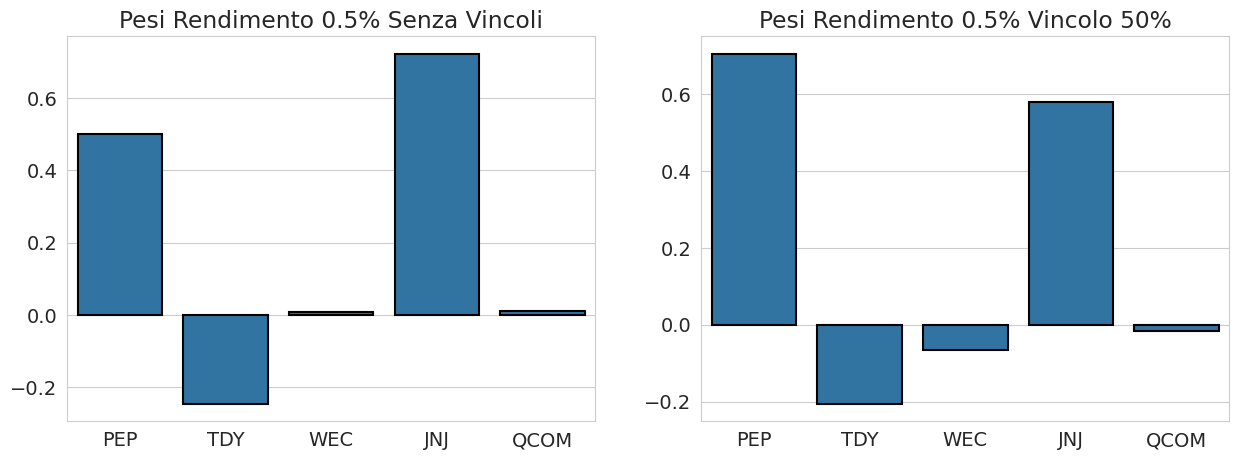

In [23]:
m = 0.5
w_05 = ((D*m-B)*inv_cov_mon@mu/det + (A-B*m)*inv_cov_mon@ones/det)
fig,ax = plt.subplots(1,2, figsize=(15, 5))

ax[0].set_title("Pesi Rendimento 0.5% Senza Vincoli")
sns.barplot(w_05,edgecolor="k",linewidth=1.5,ax=ax[0]).set_xticklabels(["PEP", "TDY", "WEC", "JNJ", "QCOM"])
ax[1].set_title("Pesi Rendimento 0.5% Vincolo 50%")
lam = (-e**2 + d*f - c*d*k + b*e*k + c*e*m - b*f*m)/(-c**2*d + 2*b*c*e - a*e**2 - b**2*f + a*d*f)
gamma = (c*e - b*f + b*c*k - a*e*k - c**2*m + a*f*m)/(-c**2*d + 2*b*c*e - a*e**2 - b**2*f + a*d*f)
delta = (-c*d + b*e - b**2*k + a*d*k + b*c*m - a*e*m)/(-c**2*d + 2*b*c*e - a*e**2 - b**2*f + a*d*f)
w_0550 = lam*inv_cov_mon@ ones +gamma*inv_cov_mon@mu +delta*inv_cov_mon@di
sns.barplot(w_0550,edgecolor="k",linewidth=1.5,ax=ax[1]).set_xticklabels(["PEP", "TDY", "WEC", "JNJ", "QCOM"])

In [24]:
print("Pesi Portafoglio Senza Vincoli al 0.5%",w_05)
print("Pesi Portafoglio Con Vincolo 50% al 0.5%",w_0550)

Pesi Portafoglio Senza Vincoli al 0.5% [ 0.50171019 -0.24538219  0.0096517   0.72280095  0.01121935]
Pesi Portafoglio Con Vincolo 50% al 0.5% [ 0.70568013 -0.20568013 -0.06623541  0.58123276 -0.01499735]


## Punto 5

Risultati CAPM Alpha and Beta
         Alpha      Beta
PEP   0.549152  2.876548
JNJ   0.468475  2.934156
QCOM  0.920833  5.087020
TDY   1.277484  6.480871
WEC   1.000683  2.759866


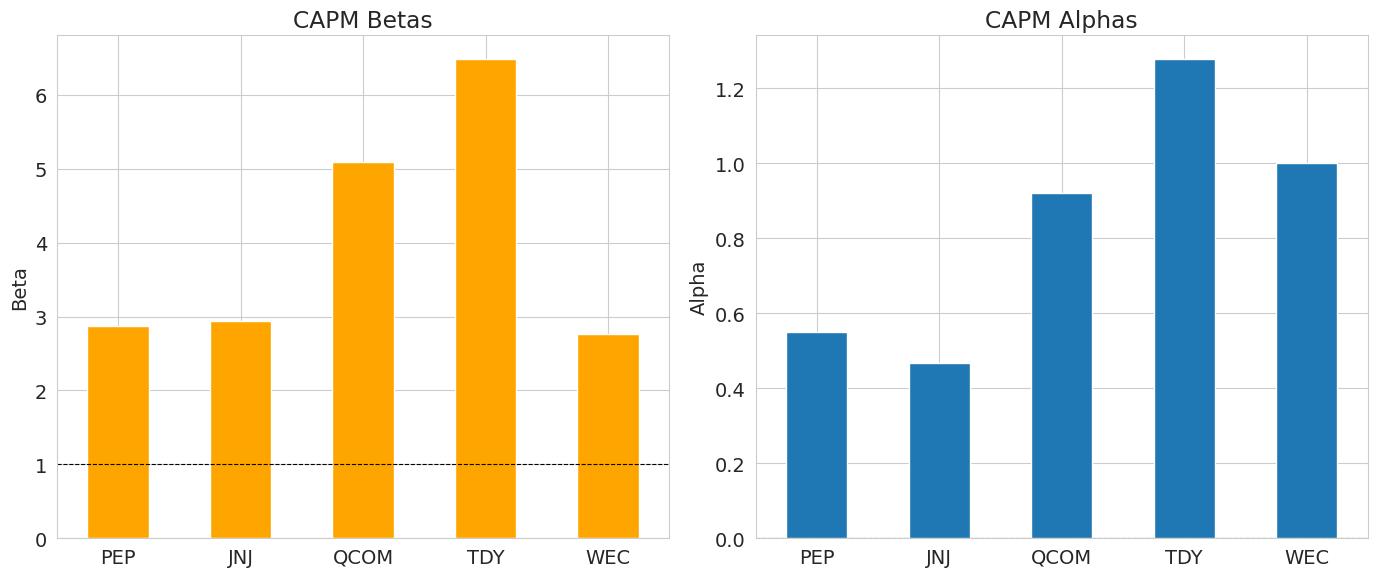


Stocks che hanno generato un Alpha positivo:
         Alpha      Beta
PEP   0.549152  2.876548
JNJ   0.468475  2.934156
QCOM  0.920833  5.087020
TDY   1.277484  6.480871
WEC   1.000683  2.759866


In [25]:
# Tasso Risk-Free annuale e mensile
rf_annual = 0.02
rf_monthly = 100*((1 + rf_annual) ** (1 / 12) - 1)

dfs = {
    'PEP': df_PEP,
    'JNJ': df_JNJ,
    'QCOM': df_QCOM,
    'TDY': df_TDY,
    'WEC': df_WEC,
}


# Preparo il DataFrame returns con i ritorni mensili
returns = pd.DataFrame()
returns['PEP'] = dfs['PEP']['1 Month Total Return']
returns['JNJ'] = dfs['JNJ']['1 Month Total Return']
returns['QCOM'] = dfs['QCOM']['1 Month Total Return']
returns['TDY'] = dfs['TDY']['1 Month Total Return']
returns['WEC'] = dfs['WEC']['1 Month Total Return']
returns['SP500'] = df_SPX['1 Month Total Return']

# Rimuovo eventuali valori nulli
returns = returns[21:] #Spx ha dati Nan per i primi 20 mesi


# Calcolo Alpha e Beta per ciascun titolo
alpha_beta_results = {}
stocks = ['PEP', 'JNJ', 'QCOM', 'TDY', 'WEC']

for stock in stocks:
    stock_excess = returns[stock] - rf_monthly
    market_excess = returns['SP500'] - rf_monthly

    # Calcolo Beta
    beta = np.cov(stock_excess, market_excess)[0, 1] / np.var(market_excess)

    # Calcolo Alpha
    alpha = np.mean(stock_excess) - beta * np.mean(market_excess)

    # Salvo i risultati
    alpha_beta_results[stock] = {
        'Alpha': alpha,
        'Beta': beta
    }

# Converto i risultati in DataFrame
alpha_beta_df = pd.DataFrame(alpha_beta_results).T

# Stampo i risultati
print("Risultati CAPM Alpha and Beta")
print(alpha_beta_df)

# Plot dei risultati
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Grafico Alpha
alpha_beta_df['Alpha'].plot(kind='bar', ax=ax[1], title='CAPM Alphas')
ax[1].set_ylabel('Alpha')
ax[1].axhline(0, color='black', linewidth=0.8, linestyle='--')
ax[1].tick_params(axis = "x",rotation=0)

# Grafico Beta
alpha_beta_df['Beta'].plot(kind='bar', ax=ax[0], title='CAPM Betas', color='orange')
ax[0].set_ylabel('Beta')
ax[0].axhline(1, color='black', linewidth=0.8, linestyle='--')
ax[0].tick_params(axis = "x",rotation=0)

plt.tight_layout()
plt.show()

# Titoli con Alpha positivo
positive_alphas = alpha_beta_df[alpha_beta_df['Alpha'] > 0]
print("\nStocks che hanno generato un Alpha positivo:")
print(positive_alphas)

Siccome non si ha la deviazione standard si esegue un t-test sulla regressione lineare.\
I valori di t significativi sono
$$ t_\beta = \frac{\hat{\beta}}{SE(\beta)}\,, $$
$$ t_\alpha = \frac{\hat{\alpha}}{SE(\alpha)}\,, $$
Dopodiché, la cosa più semplice è trovare i rispettivi valori del p-value direttamente dalla distribuzione t-student, i.e.
$$ pvalue_\beta = 2(1-CDFt_{stud}(|t_\beta|,dof))\,, $$
il numero 2 davanti deriva dal fatto che il test è a doppia coda e noi stiamo valutando $|t_\beta|$. In generale, i degree of freedom (dof) vengono calcolati come il numero di dati meno il numero dei parametri della regressione che in questo caso sono 2: ($\alpha, \beta$).\
Conclusa questa analisi, si passa a fare un F-test per determinare la significatività della regressione.

In [26]:
def fitAndStats(df):
    y = df["1 Month Total Return"][21:]
    x = df_SPX["1 Month Total Return"][21:]#Ci sono dei Nan per i primi 20 mesi

    def lfunc(x,b,a):
        return (b-rf_monthly)*x + a +rf_monthly #Regressione lineare del CAPM

    params, params_covariance = curve_fit(lfunc, x, y)
    beta, alpha = params

    print(beta,alpha)
    dof = len(x) - 2

    # genero i dati del fit
    y_fit = lfunc(x, beta, alpha)
    res = y-y_fit

    #Elementi per F-test
    SSE = np.sum(res**2)
    SST = np.sum((y - np.mean(y))**2)

    SSR = SST - SSE

    #dof F-test
    dof_res = dof -1
    MSR = SSR / 2
    MSE = SSE / dof_res

    # F-stat
    F_stat = MSR / MSE

    # p-value per l'F-stat
    p_value_F_stat = 1 - stats.f.cdf(F_stat, 2, dof_res)


    param_errors = np.sqrt(np.diag(params_covariance))

    # Errori standard dei parametri dalla matrice di covarianza
    beta_se, alpha_se = np.sqrt(np.diag(params_covariance))

    # t-statistica per beta e alpha
    t_stat_beta =  beta/ beta_se
    t_stat_alpha = alpha / alpha_se

    # Calcolo le p-value per i parametri
    p_value_beta = 2 * (1 - t.cdf(np.abs(t_stat_beta), dof))  # test doppiacoda per beta
    p_value_alpha = 2 * (1 - t.cdf(np.abs(t_stat_alpha), dof))  # test doppiacoda per alpha


    print(f"Beta: {beta:.6f}, Alpha: {alpha:.6f}")

    # Controllo significatività
    if p_value_beta < 0.05:
        print("Beta è statisticamente significativo")
    else:
        print("Beta non è statisticamente significativo")


    if p_value_alpha < 0.05:
        print("Alpha è statisticamente significativo")
    else:
        print("Alpha non è statisticamente significativo")

    print("")

    if p_value_F_stat < 0.05:
        print("Il modello è statisticamente significativo")
    else:
        print("Il modello non è statisticamente significativo")

    print("")

    return beta,alpha,p_value_beta, p_value_alpha,p_value_F_stat,p_value_F_stat< 0.05

linear_reg = pd.DataFrame(columns=["JNJ","PEP","QCOM","TDY", "WEC"], index=["Beta", "Alpha","p_value_beta","p_value_alpha","p_value_F-test","sign_F-test"])

linear_reg.loc["Beta"] = [fitAndStats(df_JNJ)[0],fitAndStats(df_PEP)[0],fitAndStats(df_QCOM)[0],fitAndStats(df_TDY)[0],fitAndStats(df_WEC)[0]]
linear_reg.loc["Alpha"] = [fitAndStats(df_JNJ)[1],fitAndStats(df_PEP)[1],fitAndStats(df_QCOM)[1],fitAndStats(df_TDY)[1],fitAndStats(df_WEC)[1]]
linear_reg.loc["p_value_beta"] = [fitAndStats(df_JNJ)[2],fitAndStats(df_PEP)[2],fitAndStats(df_QCOM)[2],fitAndStats(df_TDY)[2],fitAndStats(df_WEC)[2]]
linear_reg.loc["p_value_alpha"] = [fitAndStats(df_JNJ)[3],fitAndStats(df_PEP)[3],fitAndStats(df_QCOM)[3],fitAndStats(df_TDY)[3],fitAndStats(df_WEC)[3]]
linear_reg.loc["p_value_F-test"] = [fitAndStats(df_JNJ)[4],fitAndStats(df_PEP)[4],fitAndStats(df_QCOM)[4],fitAndStats(df_TDY)[4],fitAndStats(df_WEC)[4]]
linear_reg.loc["sign_F-test"] = [fitAndStats(df_JNJ)[5],fitAndStats(df_PEP)[5],fitAndStats(df_QCOM)[5],fitAndStats(df_TDY)[5],fitAndStats(df_WEC)[5]]

3.0865571685628677 -0.014055258749368083
Beta: 3.086557, Alpha: -0.014055
Beta è statisticamente significativo
Alpha non è statisticamente significativo

Il modello non è statisticamente significativo

3.0291989032040174 0.07609660658154116
Beta: 3.029199, Alpha: 0.076097
Beta è statisticamente significativo
Alpha non è statisticamente significativo

Il modello non è statisticamente significativo

5.2300611088729925 0.08425930286763705
Beta: 5.230061, Alpha: 0.084259
Beta non è statisticamente significativo
Alpha non è statisticamente significativo

Il modello non è statisticamente significativo

6.617852641633212 0.21168789052596915
Beta: 6.617853, Alpha: 0.211688
Beta è statisticamente significativo
Alpha non è statisticamente significativo

Il modello è statisticamente significativo

2.9130246742421564 0.5468157274518104
Beta: 2.913025, Alpha: 0.546816
Beta non è statisticamente significativo
Alpha non è statisticamente significativo

Il modello non è statisticamente significativo



In [27]:
linear_reg

,JNJ,PEP,QCOM,TDY,WEC
Beta,3.086557,3.029199,5.230061,6.617853,2.913025
Alpha,-0.014055,0.076097,0.084259,0.211688,0.546816
p_value_beta,0.025206,0.021993,0.075734,0.007037,0.05187
p_value_alpha,0.969181,0.827307,0.913809,0.743245,0.168002
p_value_F-test,0.106292,0.096076,0.228453,0.031816,0.186454
sign_F-test,False,False,False,True,False


È molto utile utilizzare il colore per visualizzare i valori statisticamente significativi o meno.\
**Rossi non significativi (Non possiamo rigettare l'ipotesi nulla), verdi significativi (Vi è sufficiente evidenza per rigettare ipotesi nulla).**

/tmp/ipykernel_33800/3071120822.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data= linear_reg.loc["Beta"],edgecolor="black",palette = Color_Beta,linewidth=1.5,ax=ax[0])
/tmp/ipykernel_33800/3071120822.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data= linear_reg.loc["Alpha"],edgecolor="black",palette = Color_Alpha,linewidth=1.5,ax=ax[1])


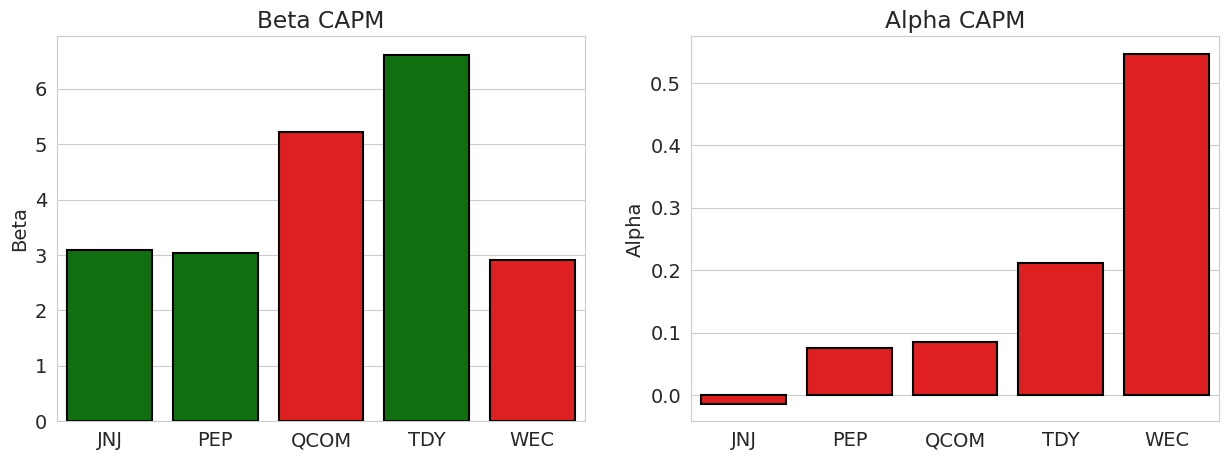

In [28]:
 # Se statisticamente significativo è verde altrimenti rosso
Color_Beta = ["red" if value > 0.05 else "green" for value in linear_reg.loc["p_value_beta"]]
Color_Alpha = ["red" if value > 0.05 else "green" for value in linear_reg.loc["p_value_alpha"]]

sns.set_style("whitegrid")
fig,ax = plt.subplots(1,2, figsize=(15, 5))

ax[0].set_title("Beta CAPM")
sns.barplot(data= linear_reg.loc["Beta"],edgecolor="black",palette = Color_Beta,linewidth=1.5,ax=ax[0])
ax[1].set_title("Alpha CAPM")
sns.barplot(data= linear_reg.loc["Alpha"],edgecolor="black",palette = Color_Alpha,linewidth=1.5,ax=ax[1])
plt.show()

## Punto 6

## 1) Rendimenti Impliciti:

In [29]:
# Includo S&P 500 nei calcoli
df_return_month["Monthly return SPX"] = df_SPX["1 Month Total Return"].values
cov_mon = df_return_month.cov(numeric_only=True).values

inv_cov_mon = np.linalg.inv(cov_mon)

mu = df_return_month.mean().to_numpy()

# mu_p è l'expected return del portafoglio, mentre mu dei singoli assets
mu_p = np.dot(inv_cov_mon, mu)

e = np.ones(len(mu_p))
A = inv_cov_mon @ mu @ mu
B = inv_cov_mon @ mu @ e
D = inv_cov_mon @ e @ e

# w sono i pesi del portafoglio ottimale, massimizando lo sharp ratio.
w = mu_p/B

In [30]:
# il delta può essere 2 oppure possiamo calcolarlo noi con la varianze e rendimenti
delta = (mu_p - Rf_mon)/(cov_mon@w@w)

# Calcolo dei rendimenti impliciti
rendimenti_impliciti = delta * cov_mon@w

print(rendimenti_impliciti)

[ 8.16653338 18.49891617  7.2901535   8.47487685 14.50471243  2.97117917]


## 2) Calcolo rendimento del Portafoglio di Mercato

In [31]:
# Rendimento atteso del portafoglio di mercato
Rendimento_del_PM = w @ rendimenti_impliciti

print(Rendimento_del_PM)

3.032212809951408


## Punto 7

In [32]:
# Definizione delle opinioni:
# Opinione Aumento Stock1: "Ci aspettiamo che Stock1 superi il rendimento implicito del mercato del 5%."
# Opinione Riduzione Stock3: "Ci aspettiamo che Stock3 sottoperformi rispetto al rendimento implicito del mercato del 3%."
Opinioni = np.array([0.05, -0.03])

# Matrice P (opinioni)
P = np.array([[1, 0, 0, 0, 0, 0],   # Opinione su Stock1
              [0, 0, 1, 0, 0, 0]]) # Opinione su Stock3

# Matrice Omega (covarianza delle opinioni)
omega = np.diag([0.1, 0.1]) # Assumendo una incertezza

# Calcolo del nuovo rendimento atteso usando Black-Litterman

tau = 0.05 # Un valore comune per tau τ è un parametro scalare che viene utilizzato per controllare il peso delle opinioni
# degli investitori rispetto alle informazioni di mercato. Esso riflette quanto si considera "forte" la propria opinione
# rispetto ai rendimenti impliciti del mercato.
pi = rendimenti_impliciti

# Formula Black-Litterman
M_inverse = np.linalg.inv(np.linalg.inv(tau * cov_mon ) + P.T @ np.linalg.inv(omega) @ P)
Rendimento_atteso_Blacklitterman = M_inverse @ (np.linalg.inv(tau * cov_mon ) @ pi + P.T @ np.linalg.inv(omega) @ Opinioni)

print(Rendimento_atteso_Blacklitterman)
print(rendimenti_impliciti)

[ 0.72836919 13.10914414  0.37089059  3.09501882 10.22952284  2.90385013]
[ 8.16653338 18.49891617  7.2901535   8.47487685 14.50471243  2.97117917]


In [33]:
tickers = ["PEP", "JNJ", "QCOM", "TDY", "WEC","SPX"]
cov_mon = pd.DataFrame(cov_mon, index=tickers, columns=tickers)

viewdict = {"PEP": 0.05, "JNJ": 0, "QCOM": -0.03, "TDY": 0, "WEC": 0,"SPX":0}
q = [0.05,0,-0.03,0,00]


bl = BlackLittermanModel(cov_mon, absolute_views=viewdict)

rets = bl.bl_returns()
ef = EfficientFrontier(rets, cov_mon)

print(rendimenti_impliciti + rendimenti_impliciti*rets) # Rendimenti black litterman
print(rendimenti_impliciti)
rets

PEP      8.322531
JNJ     18.538076
QCOM     7.220801
TDY      8.521210
WEC     14.572069
SPX      2.971252
dtype: float64
[ 8.16653338 18.49891617  7.2901535   8.47487685 14.50471243  2.97117917]


/home/riccardomartelli/.local/lib/python3.13/site-packages/pypfopt/black_litterman.py:259: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")


PEP     0.019102
JNJ     0.002117
QCOM   -0.009513
TDY     0.005467
WEC     0.004644
SPX     0.000024
dtype: float64

Valori Intrinseci:
JNJ: 125.89743589743588
PEP: 260.5769230769231
QCOM: 133.3333333333333
WEC: 119.39799331103674

Rendimenti Impliciti:
JNJ: 9.457724133214798%
PEP: 11.108235294117648%
QCOM: 10.283333333333333%
WEC: 10.976666666666665%


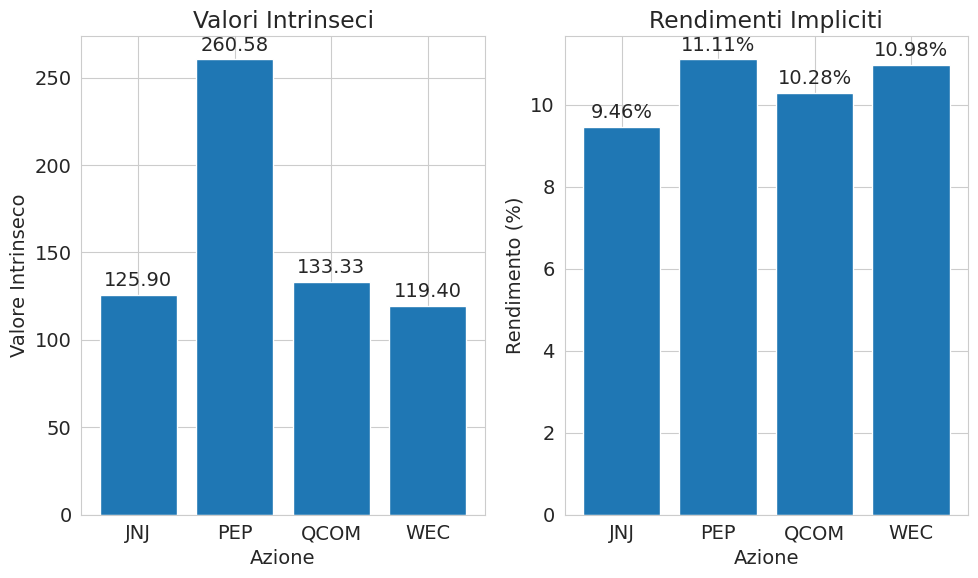

In [34]:
# Dati finanziari delle azioni
stocks_data = {
    'JNJ': {'dividendi per azioni': 4.91, 'tasso_di_crescita': 0.061},
    'PEP': {'dividendi per azioni': 5.42, 'tasso_di_crescita': 0.0792},
    'QCOM': {'dividendi per azioni': 3.40, 'tasso_di_crescita': 0.0745},
    'WEC': {'dividendi per azioni': 3.57, 'tasso_di_crescita': 0.0701}
}

# Tasso di attualizzazione
discount_rate = 0.10  # 10%

# Prezzi di mercato attuali
prezzi_mercato = {
    'JNJ': 146.23,
    'PEP': 170.00,
    'QCOM': 120.00,
    'WEC': 90.00
}

# Funzione per calcolare il valore intrinseco con il modello di crescita di Gordon
def gordon(dividendi, tasso_di_crescita, tasso_di_attualizzazione):
    if tasso_di_attualizzazione <= tasso_di_crescita:
        return None  # Non valido
    return dividendi / (tasso_di_attualizzazione - tasso_di_crescita)

# Calcolo dei valori intrinseci
valori_intrinseci = {}
for azione, dati in stocks_data.items():
    valore_intrinseco = gordon(dati['dividendi per azioni'], dati['tasso_di_crescita'], discount_rate)
    valori_intrinseci[azione] = valore_intrinseco

# Calcolo dei rendimenti impliciti
rendimenti_impliciti = {}
for azione, valore_intrinseco in valori_intrinseci.items():
    if valore_intrinseco is not None:
        rendimento_implicito = (stocks_data[azione]['dividendi per azioni'] / prezzi_mercato[azione]) + stocks_data[azione]['tasso_di_crescita']
        rendimenti_impliciti[azione] = rendimento_implicito * 100  # Moltiplica per 100 per esprimere come percentuale

# Preparazione dei dati per il grafico
azioni = list(valori_intrinseci.keys())
valori_intrinseci_list = [valore if valore is not None else 0 for valore in valori_intrinseci.values()]
rendimenti_impliciti_list = [rendimenti_impliciti.get(azione, 0) for azione in azioni]

# Stampa i valori esatti
print("Valori Intrinseci:")
for azione, valore in valori_intrinseci.items():
    print(f"{azione}: {valore if valore is not None else 'Non calcolabile'}")

print("\nRendimenti Impliciti:")
for azione, valore in rendimenti_impliciti.items():
    print(f"{azione}: {valore}%")

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.bar(azioni, valori_intrinseci_list)
plt.title('Valori Intrinseci')
plt.xlabel('Azione')
plt.ylabel('Valore Intrinseco')

# Aggiungi i valori ai bar
for i, valore in enumerate(valori_intrinseci_list):
    plt.text(i, valore + (max(valori_intrinseci_list) * 0.01), f"{valore:.2f}", ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.bar(azioni, rendimenti_impliciti_list)
plt.title('Rendimenti Impliciti')
plt.xlabel('Azione')
plt.ylabel('Rendimento (%)')

# Aggiungi i valori ai bar
for i, valore in enumerate(rendimenti_impliciti_list):
    plt.text(i, valore + (max(rendimenti_impliciti_list) * 0.01), f"{valore:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [35]:
for azione, valore in valori_intrinseci.items():
  print(f"Il prezzo secondo Gordon per {azione} è: {valore}")

Il prezzo secondo Gordon per JNJ è: 125.89743589743588
Il prezzo secondo Gordon per PEP è: 260.5769230769231
Il prezzo secondo Gordon per QCOM è: 133.3333333333333
Il prezzo secondo Gordon per WEC è: 119.39799331103674
